In [103]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_rel, wilcoxon
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from scipy.stats import loguniform
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics import r2_score
#Le R² varie de 0 à 1, où une valeur de 1 indique que le modèle ajuste parfaitement les données et explique 100% de la variance de la variable dépendante, 
# #tandis qu'une valeur de 0 indique que le modèle ne parvient pas à expliquer la variance de la variable dépendante et que les prédictions sont équivalentes à 
# la moyenne des données.
#En général, un R² plus élevé indique que le modèle ajuste mieux les données et explique une plus grande proportion de la variance de la variable dépendante. 
# Cependant, il est important de noter que le R² ne doit pas être utilisé comme seul critère pour évaluer la qualité d'un modèle, 


from sklearn.metrics import mean_absolute_error

from sklearn.feature_selection import RFE
#on entraine les hyper parametree avant ou apres avoir selectionné les variables

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [104]:
wines_ = pd.read_excel("data/Subset1.xls", 1)
print(min(wines_['DOY']))

213.0


On ne peut donc au maximum prendre comme data que les 213 jours précédent la récolte, une information supplémentaire n'est probablement pas importante car on va surtout analyser l'effet de la météo d'une année sur le vin

In [105]:
wines_.dropna(subset = ['Harvest date'], inplace=True)
wines_.reset_index(drop=True, inplace=True)

In [106]:
weather = pd.read_excel("data/Subset3.xls", [1,2,3,4,5])
weather[1]

,Year,Month,day,Tave,Tmax,Tmin,DOY,Unnamed: 7,Year.1,GST,WI,HI
0,1911,1,1,8.35,16.7,0.0,1,NaN,1911.0,15.073364,1099.050000,967.254052
1,1911,1,2,8.85,19.4,-1.7,2,NaN,1912.0,15.752336,1246.550000,1146.450272
2,1911,1,3,6.65,16.1,-2.8,3,NaN,1913.0,16.722430,1446.300000,1276.779404
3,1911,1,4,8.30,18.3,-1.7,4,NaN,1914.0,15.678579,1217.966001,1103.276910
4,1911,1,5,7.80,18.9,-3.3,5,NaN,1915.0,15.950196,1277.291993,1133.617078
...,...,...,...,...,...,...,...,...,...,...,...,...
36885,2011,12,27,6.95,15.6,-1.7,361,NaN,NaN,NaN,NaN,NaN
36886,2011,12,28,11.65,19.4,3.9,362,NaN,NaN,NaN,NaN,NaN
36887,2011,12,29,11.15,16.7,5.6,363,NaN,NaN,NaN,NaN,NaN
36888,2011,12,30,12.20,15.0,9.4,364,NaN,NaN,NaN,NaN,NaN


In [107]:
i = list(range(1,201))
i = list(map(str, i))
iavg = ['avg' + item for item in i]
imin = ['min' + item for item in i]
imax = ['max' + item for item in i]
temp_avg = pd.DataFrame(columns = iavg)
temp_min = pd.DataFrame(columns = imin)
temp_max = pd.DataFrame(columns = imax)

In [108]:
wines = wines_.copy()

In [109]:
for i in range(len(wines)):
    new_row = []
    r = wines["Reg"][i]
    d = wines['Harvest date'][i]
    h = int(wines['DOY'][i])
    new_row = list(weather[r].loc[(weather[r]['Year'] == d.year) & (weather[r]['DOY'].isin(range(h-200,h)))]['Tave'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_avg.loc[len(temp_avg)] = new_row

In [110]:
for i in range(len(wines)):
    new_row = []
    r = wines["Reg"][i]
    d = wines['Harvest date'][i]
    h = int(wines['DOY'][i])
    new_row = list(weather[r].loc[(weather[r]['Year'] == d.year) & (weather[r]['DOY'].isin(range(h-200,h)))]['Tmin'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_min.loc[len(temp_min)] = new_row

In [111]:
for i in range(len(wines)):
    new_row = []
    r = wines["Reg"][i]
    d = wines['Harvest date'][i]
    h = int(wines['DOY'][i])
    new_row = list(weather[r].loc[(weather[r]['Year'] == d.year) & (weather[r]['DOY'].isin(range(h-200,h)))]['Tmax'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_max.loc[len(temp_max)] = new_row

In [112]:
print(temp_avg.isnull().sum(axis = 0))
print(temp_min.isnull().sum(axis = 0))
print(temp_max.isnull().sum(axis = 0))

avg1      102
avg2      102
avg3      102
avg4      102
avg5      102
         ... 
avg196    102
avg197    102
avg198    102
avg199    102
avg200    102
Length: 200, dtype: int64
min1      102
min2      102
min3      102
min4      102
min5      102
         ... 
min196    102
min197    102
min198    102
min199    102
min200    102
Length: 200, dtype: int64
max1      102
max2      102
max3      102
max4      102
max5      102
         ... 
max196    102
max197    102
max198    102
max199    102
max200    102
Length: 200, dtype: int64


we have the same missing values for Tmin, Tmax and Taverage

In [162]:
all_temp = pd.concat([temp_min,temp_max], axis = 1)

# Now to aggregate the temperatures

### choose the time spans with ```nb_jour```

In [114]:
nb_jour = 5

In [115]:
#reduction de dimension, ca enleve la variabilité des données qui correspondent au bruit donc ca permet de savoir ce qu'est vraiment nos données
#elimination de variable, on entraine un modele sur nos donneés, on trouve la variable (l'attribut) qui contirbue le moins et on la supprimes

#fonction qui prend en argument le chiffre par lequel on va partioonner notre dataset : exemple 10 alors il y aura 10 colonnes 
#de temperature qui vont prendre la moyenne des 20 jours sur lequel ils sont
def colonne_nb_jour_avg(nb_jour):
    temperatures_bis = pd.DataFrame()
    addition = temp_avg.shape[1]//nb_jour
    if temp_avg.shape[1]%nb_jour !=0:
        print("trouver une autre valeur")
    else:
        for index in range(nb_jour): 
            colonnes = []
            for i in range(index*addition+1, index*addition+ addition +1):
                colonnes.append(f"avg{i}")  
            moyenne = temp_avg[colonnes].mean(axis=1)
            temperatures_bis[f"s{nb_jour}avg{index + 1}"] = moyenne
    return temperatures_bis

In [116]:
def colonne_nb_jour_min(nb_jour):
    temperatures_bis = pd.DataFrame()
    addition = temp_min.shape[1]//nb_jour
    if temp_min.shape[1]%nb_jour !=0:
        print("trouver une autre valeur")
    else:
        for index in range(nb_jour): 
            colonnes = []
            for i in range(index*addition+1, index*addition+ addition +1):
                colonnes.append(f"min{i}")  
            min = temp_min[colonnes].mean(axis=1)
            temperatures_bis[f"s{nb_jour}min{index + 1}"] = min
    return temperatures_bis

In [117]:
def colonne_nb_jour_max(nb_jour):
    temperatures_bis = pd.DataFrame()
    addition = temp_max.shape[1]//nb_jour
    if temp_max.shape[1]%nb_jour !=0:
        print("trouver une autre valeur")
    else:
        for index in range(nb_jour): 
            colonnes = []
            for i in range(index*addition+1, index*addition+ addition +1):
                colonnes.append(f"max{i}")  
            max = temp_max[colonnes].mean(axis=1)
            temperatures_bis[f"s{nb_jour}max{index + 1}"] = max
    return temperatures_bis

In [163]:
agg_temp_min = colonne_nb_jour_min(nb_jour)
agg_temp_max =colonne_nb_jour_max(nb_jour)
agg_temp_avg=colonne_nb_jour_avg(nb_jour)

agg_all_temp = pd.concat([agg_temp_min,agg_temp_max], axis = 1)

In [119]:
def count_values_in_interval(row, interval_start, interval_end):
    count = 0
    for val in row:
        if interval_start <= val < interval_end:
            count += 1
    return count

In [120]:
#choice = 2 pour utiliser avg, 1 pour min 3 pour max
#il faudra le faire sur les données preprocess ici par le cas 
def intervalle(choice):
    if choice == 1:
        temp= temp_min
    if choice == 2:
        temp= temp_avg
    if choice == 3:
        temp= temp_max
    df = pd.DataFrame()
    df[f"{choice}intervalle_-5"] = temp.apply(lambda row: count_values_in_interval(row, -50, -5), axis=1)
    df[f"{choice}intervalle_-5-0"] = temp.apply(lambda row: count_values_in_interval(row, -5, 0), axis=1)
    df[f"{choice}intervalle_0-5"] = temp.apply(lambda row: count_values_in_interval(row, 0, 5), axis=1)
    df[f"{choice}intervalle_5-10"] = temp.apply(lambda row: count_values_in_interval(row, 5, 10), axis=1)
    df[f"{choice}intervalle_10-15"] = temp.apply(lambda row: count_values_in_interval(row, 10, 15), axis=1)
    df[f"{choice}intervalle_15-20"] = temp.apply(lambda row: count_values_in_interval(row, 15, 20), axis=1)
    df[f"{choice}intervalle_20-25"] = temp.apply(lambda row: count_values_in_interval(row, 20, 25), axis=1)
    df[f"{choice}intervalle_25-30"] = temp.apply(lambda row: count_values_in_interval(row, 25, 30), axis=1)
    df[f"{choice}intervalle_30-35"] = temp.apply(lambda row: count_values_in_interval(row, 30, 35), axis=1)
    df[f"{choice}intervalle_35-40"] = temp.apply(lambda row: count_values_in_interval(row, 35, 40), axis=1)
    df[f"{choice}intervalle_40-"] = temp.apply(lambda row: count_values_in_interval(row, 40, 100), axis=1)
    return df

In [164]:
int_temp_min = intervalle(1)
int_temp_max =intervalle(2)
int_temp_avg=intervalle(3)

int_all_temp= pd.concat([int_temp_min,int_temp_max], axis = 1)

In [122]:
def count_above_thresh(row, t):
    return (row > t).sum()

def days_over(choice = 'max'):
    if choice == 'min':
        temp= temp_min
    if choice == 'avg':
        temp= temp_avg
    if choice == 'max':
        temp= temp_max
    columns = list(range(int(temp.min().min())+1,int(temp.max().max())))
    df = pd.DataFrame()
    for num in columns:
        col_name = f"Over_{num}{choice}"
        df[col_name] = temp.apply(lambda row: (row >= num).sum(), axis=1)
    return df

In [123]:
temp_max_over = days_over(choice = 'max')
temp_min_over = days_over(choice = 'min')
both_over = pd.concat([temp_max_over,temp_min_over], axis = 1)

# Choose the temperature chosen

* ```temp_min``` - the minimal temperatures for each day
* ```temp_avg``` - the average temperatures for each day
* ```temp_max``` - the maximal temperatures for each day
* ```all_temp``` - the concatenation of the previous three
* ```agg_temp_min``` - the min temperatures averaged over periods of ```nb_jour```
* ```agg_temp_avg``` - the avg temperatures averaged over periods of ```nb_jour```
* ```agg_temp_max``` - the max temperatures averaged over periods of ```nb_jour```
* ```agg_all_temp``` - the concatenation of the previous three
* ```int_temp_min``` - number of days where temp min in intervals
* ```int_temp_max``` - number of days where temp max in intervals
* ```int_temp_avg``` - number of days where temp avg in intervals
* ```int_all_temp``` - the concatenation of the previous three
* ```temp_max_over``` - days over threshold temperatures for tmax
* ```temp_min_over``` _ days over threshold temperatures for tmin
* ```both_over``` - the two above


In [124]:
temperatures = both_over.copy()
temperatures

,Over_5max,Over_6max,Over_7max,Over_8max,Over_9max,Over_10max,Over_11max,Over_12max,Over_13max,Over_14max,...,Over_16min,Over_17min,Over_18min,Over_19min,Over_20min,Over_21min,Over_22min,Over_23min,Over_24min,Over_25min
0,200,200,200,200,200,200,199,198,195,192,...,5,2,0,0,0,0,0,0,0,0
1,200,200,200,200,200,200,199,199,197,194,...,7,6,3,2,2,1,0,0,0,0
2,200,200,200,200,200,200,200,200,199,198,...,0,0,0,0,0,0,0,0,0,0
3,200,200,200,200,200,200,200,198,194,190,...,6,4,2,1,1,0,0,0,0,0
4,200,200,200,200,200,200,200,200,200,196,...,3,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,200,200,200,200,200,200,200,200,200,200,...,9,4,3,2,0,0,0,0,0,0
1469,200,200,200,200,200,200,200,200,199,199,...,4,2,1,1,1,0,0,0,0,0
1470,200,200,200,200,200,200,200,200,200,200,...,12,7,4,4,4,2,0,0,0,0
1471,200,200,200,200,200,200,200,200,200,199,...,9,4,3,2,0,0,0,0,0,0


In [125]:
mapping = {'White': -1, 'Red': 1}

wines['Color'] = wines['Color'].map(mapping).fillna(wines['Color'])
wines

,Table.No.,Cultivar,Color,Recommend,RecReg,Reg,Harvest date,DOY,Must.Brix,Must.Tacid,Must.pH,Wine.Alcohol,Wine.Facid,Wine.Extract,Wine.Tannin,Wine.Tasting
0,9,Chardony,-1,Particularly recommended,1.0,3,1936-09-08,251.0,27.2,0.54,3.88,15.6,0.42,4.0,0.03,"Very distinct; good, but alcoholic"
1,9,Chardony,-1,Particularly recommended,1.0,4,1936-08-31,243.0,23.5,0.67,3.79,13.0,0.39,NaN,NaN,Distinct; lacks acid; standard quality
2,9,Chardony,-1,Particularly recommended,1.0,1,1937-10-01,273.0,22.1,0.72,3.38,12.0,0.52,2.0,0.03,Light body; fruity; distinct; good quality
3,9,Chardony,-1,Particularly recommended,1.0,3,1937-09-11,253.0,24.6,0.63,3.69,12.8,0.49,2.1,0.03,Flat; tends to oxidize; but distinct
4,9,Chardony,-1,Particularly recommended,1.0,1,1938-09-14,256.0,19.8,0.78,3.19,10.5,0.68,2.8,0.07,"Tart, but palatable; distinct; picked too early"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,25,Red Malaga (Molinera),1,Table grape,NaN,4,1937-10-25,297.0,21.8,0.47,3.74,12.0,0.28,2.3,0.04,Very flat; some spoilage; very ordiry sherry
1469,25,Red Malaga (Molinera),1,Table grape,NaN,4,1940-10-07,280.0,22.7,0.36,3.90,12.4,0.40,2.8,0.04,Flat; pink; very common; lacks everything
1470,25,Ribier,1,Table grape,NaN,4,1935-11-01,304.0,20.2,0.55,NaN,10.8,0.34,2.5,0.08,"Flat; poor; sherry; soft, but no character"
1471,25,Ribier,1,Table grape,NaN,4,1937-10-13,285.0,17.6,0.50,3.58,9.5,0.35,2.1,0.06,Flat; ordiry; tends to spoil


In [126]:
dataset = pd.concat([wines,temperatures], axis = 1)

In [127]:
print(dataset.isna().sum()) #il faudrait trouver et enlever les 102 wines ou on a pas la temperature selon mon avis 

Table.No.        0
Cultivar         0
Color            0
Recommend        0
RecReg        1025
              ... 
Over_21min       0
Over_22min       0
Over_23min       0
Over_24min       0
Over_25min       0
Length: 86, dtype: int64


# Mise en place d'une analyse avec tout d'abord la color du wine comme attribute et le ph à prédire

In [393]:
tested = 'Wine.Tannin'
to_drop = ['Table.No.', 'Cultivar', 'Recommend', 'RecReg', 'Reg', 'Must.pH','Wine.Alcohol',
       'Harvest date', 'DOY', 'Must.Brix', 'Must.Tacid', 'Wine.Facid', 'Wine.Extract', 'Wine.Tannin',
       'Wine.Tasting']
to_drop.remove(tested)

In [394]:
copie = dataset.copy()
#enlever les colonnes qu'on ne compte pas utiliser
copie = copie.drop(columns = to_drop)
#verifier qu'on a nos colonnes désirées
copie.columns 

Index(['Color', 'Wine.Tannin', 'Over_5max', 'Over_6max', 'Over_7max',
       'Over_8max', 'Over_9max', 'Over_10max', 'Over_11max', 'Over_12max',
       'Over_13max', 'Over_14max', 'Over_15max', 'Over_16max', 'Over_17max',
       'Over_18max', 'Over_19max', 'Over_20max', 'Over_21max', 'Over_22max',
       'Over_23max', 'Over_24max', 'Over_25max', 'Over_26max', 'Over_27max',
       'Over_28max', 'Over_29max', 'Over_30max', 'Over_31max', 'Over_32max',
       'Over_33max', 'Over_34max', 'Over_35max', 'Over_36max', 'Over_37max',
       'Over_38max', 'Over_39max', 'Over_40max', 'Over_41max', 'Over_42max',
       'Over_43max', 'Over_44max', 'Over_-4min', 'Over_-3min', 'Over_-2min',
       'Over_-1min', 'Over_0min', 'Over_1min', 'Over_2min', 'Over_3min',
       'Over_4min', 'Over_5min', 'Over_6min', 'Over_7min', 'Over_8min',
       'Over_9min', 'Over_10min', 'Over_11min', 'Over_12min', 'Over_13min',
       'Over_14min', 'Over_15min', 'Over_16min', 'Over_17min', 'Over_18min',
       'Over_19min

In [395]:
columns = list(temperatures.columns)
columns.append('Color')
columns.append(tested)
#delete row with value = Nan
#voir si pour les y on peut pas remplacer par une valeur :
# d'autres possibilités (ffill et bfill qui propagent les valeurs observées aux voisines Nan)
# imputation par la moyenne (possible aussi avec la mediane)
# exemple :           movies_df['budget'].fillna(movies_df['budget'].mean(), inplace=True)
copie.dropna(subset = columns, inplace=True)
copie.reset_index(drop=True, inplace=True)

In [396]:
# classe à prédire
y = copie[[tested]]

colonnes = list(temperatures.columns)
colonnes.append('Color')

X = copie[colonnes]
X

,Over_5max,Over_6max,Over_7max,Over_8max,Over_9max,Over_10max,Over_11max,Over_12max,Over_13max,Over_14max,...,Over_17min,Over_18min,Over_19min,Over_20min,Over_21min,Over_22min,Over_23min,Over_24min,Over_25min,Color
0,200,200,200,200,200,200,199,198,195,192,...,2,0,0,0,0,0,0,0,0,-1
1,200,200,200,200,200,200,200,200,199,198,...,0,0,0,0,0,0,0,0,0,-1
2,200,200,200,200,200,200,200,198,194,190,...,4,2,1,1,0,0,0,0,0,-1
3,200,200,200,200,200,200,200,200,200,196,...,2,0,0,0,0,0,0,0,0,-1
4,200,200,200,200,200,200,200,199,198,190,...,1,0,0,0,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,200,200,200,200,200,200,200,199,199,196,...,7,4,4,4,2,0,0,0,0,1
1436,200,200,200,200,200,200,200,200,200,200,...,4,3,2,0,0,0,0,0,0,1
1437,200,200,200,200,200,200,200,200,199,199,...,2,1,1,1,0,0,0,0,0,1
1438,200,200,200,200,200,200,200,200,200,200,...,7,4,4,4,2,0,0,0,0,1


In [397]:
def plot_true_vs_predicted(y_true, y_pred):
    """
    Trace un graphique de dispersion des vraies valeurs (y_true) par rapport aux valeurs prédites (y_pred).
    y_true : array de shape (n_samples,)
        Les vraies valeurs de la variable cible.
    y_pred : array de shape (n_samples,)
        Les valeurs prédites de la variable cible.
    """
    min_value = min(min(y_true), min(y_pred))
    max_value = max(max(y_true), max(y_pred))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(y_true, y_pred, s=30, alpha=0.5)
    ax.set_xlabel("Valeurs réelles")
    ax.set_ylabel("Valeurs prédites")
    ax.set_xlim([min_value, max_value])
    ax.set_ylim([min_value, max_value])
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.set_title("Valeurs réelles vs. Valeurs prédites")
    plt.show()

In [398]:
def plot_residuals(y_true, y_pred):
    """
    Trace un histogramme des résidus.
    y_true : array de shape (n_samples,)
        Les vraies valeurs de la variable cible.
    y_pred : array de shape (n_samples,)
        Les valeurs prédites de la variable cible.
    """
    residuals = y_true - y_pred
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.hist(residuals, bins=30)
    ax.set_xlabel('Résidus')
    ax.set_ylabel('Fréquence')
    ax.set_title('Histogramme des résidus')
    ax.axvline(np.mean(residuals), color='red', linestyle='dashed', linewidth=1)
    plt.show()

In [399]:
def plot_scores(k):
    m=exp_models[k]
    mean_test_scores = m.cv_results_['mean_test_mse']
    mean_test_r2_scores = m.cv_results_['mean_test_r2']
    std_test_score = m.cv_results_['std_test_mse']
    std_test_r2_scores = m.cv_results_['std_test_r2']
    best_i = m.best_index_

    plt.figure(figsize=(8, 6))
    plt.errorbar(mean_test_scores, mean_test_r2_scores, xerr = std_test_score ,yerr=std_test_r2_scores, fmt='o', capsize=5)
    plt.scatter(mean_test_scores[best_i], mean_test_r2_scores[best_i], color='red', s=50, zorder=10)
    plt.xlabel('MSE')
    plt.ylabel('R2 Score')
    plt.title(f'{k} Test R2 vs. neg MSE')
    plt.show()

In [400]:
def plot_hists(y_true, y_pred):
    min_value = min(min(y_true), min(y_pred))
    max_value = max(max(y_true), max(y_pred))

    plt.hist(y_pred, bins=30, range=(min_value, max_value), color='blue', alpha=0.5, label='Predicted')
    plt.hist(y_true, bins=30, range=(min_value, max_value), color='green', alpha=0.5, label='True')

    plt.title('Histograms of Predicted and True Values')
    plt.xlabel('Values')
    plt.ylabel('Frequency')

    plt.legend(loc='upper right')

    plt.show()

In [401]:
def trend_param(k, p):
    model = exp_models[k]
    results = model.cv_results_
    mean_test_score = -results['mean_test_mse']
    std_test_score = results['std_test_mse']
    param_values = results[f'param_mod__{p}']

    plt.errorbar(param_values, mean_test_score, yerr=std_test_score, fmt='o')
    plt.xlabel(f'log10({p})')
    plt.ylabel('Mean Test Score')
    plt.title('Linear Kernel')
    plt.show()

def trend_param_log(k, p):
    model = exp_models[k]
    results = model.cv_results_
    mean_test_score = -results['mean_test_mse']
    std_test_score = results['std_test_mse']
    param_values = np.array([np.log10(float(c)) for c in results[f'param_mod__{p}']])

    plt.errorbar(param_values, mean_test_score, yerr=std_test_score, fmt='o')
    plt.xlabel(f'log10({p})')
    plt.ylabel('Mean Test Score')
    plt.title('Linear Kernel')
    plt.show()

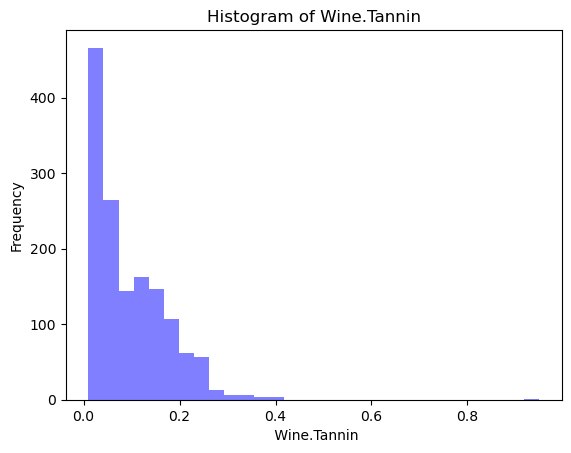

In [402]:
values_to_plot = copie[tested]

# Create the histogram
plt.hist(values_to_plot, bins=30, color='blue', alpha=0.5)

# Set the title and axis labels
plt.title(f'Histogram of {tested}')
plt.xlabel(f' {tested}')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [403]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [404]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), temperatures.columns)  
    ],
    remainder='passthrough' 
)

exp_models = {}


In [405]:
scorers = {
    'mse': make_scorer(mean_squared_error, squared = False, greater_is_better=False),
    'r2': make_scorer(r2_score)
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)

#linear regression avec lasso et ridge 
alphas = loguniform(1e-5, 2e1)

param_dist = {'mod__alpha': alphas}

pLasso = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', Lasso())
])

pRidge = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', Ridge())
])

rand_lass = RandomizedSearchCV(pLasso, param_distributions=param_dist, scoring=scorers, refit='mse',verbose=1, n_iter=40, cv=cv, random_state=7)
rand_rid = RandomizedSearchCV(pRidge, param_distributions=param_dist, scoring=scorers, refit='mse',verbose=1, n_iter=40, cv=cv, random_state=7)


rand_lass.fit(X_train, y_train.values.ravel())
rand_rid.fit(X_train, y_train.values.ravel())

exp_models["rand_lass"]=rand_lass
exp_models["rand_rid"]=rand_rid


print("Best hyperparameters: ", rand_lass.best_params_)
print("Cross-validation score: ", rand_lass.best_score_)

print("Best hyperparameters: ", rand_rid.best_params_)
print("Cross-validation score: ", rand_rid.best_score_)



Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/augustin/Documents/M1/projectML/project/projet_wine/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e-01, tolerance: 5.335e-04
  model = cd_fast.enet_coordinate_descent(
/home/augustin/Documents/M1/projectML/project/projet_wine/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.587e-01, tolerance: 5.293e-04
  model = cd_fast.enet_coordinate_descent(
/home/augustin/Documents/M1/projectML/project/projet_wine/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best hyperparameters:  {'mod__alpha': 6.904061832285474e-05}
Cross-validation score:  -0.05327788423347224
Best hyperparameters:  {'mod__alpha': 7.371520238064511}
Cross-validation score:  -0.05325098705093982


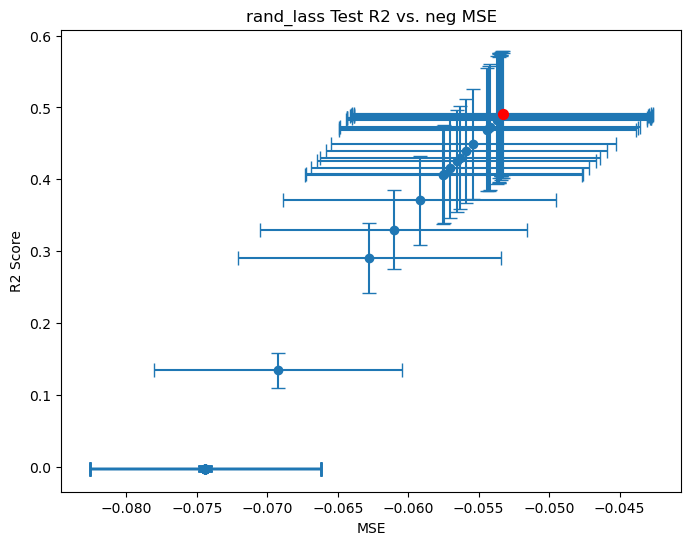

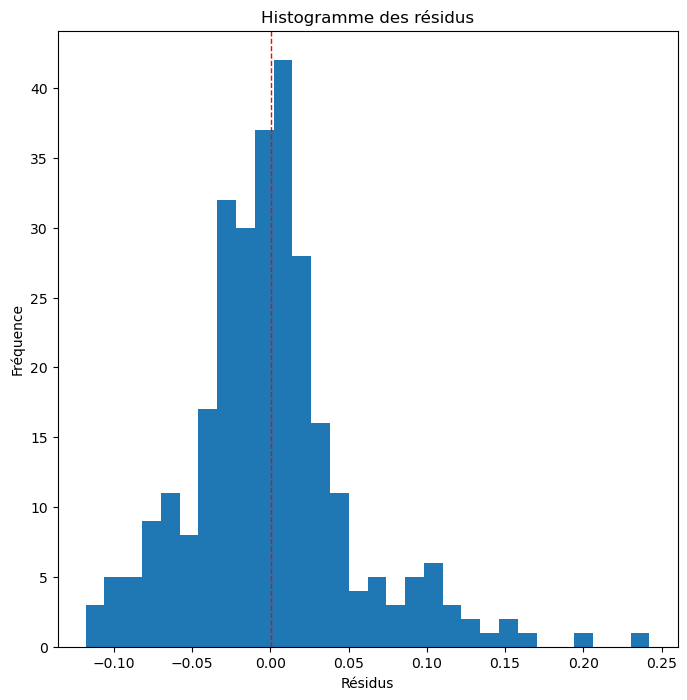

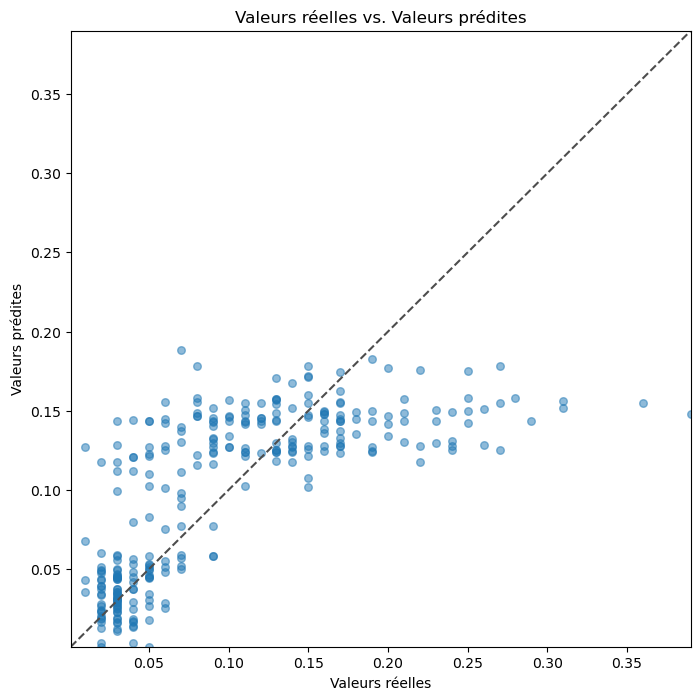

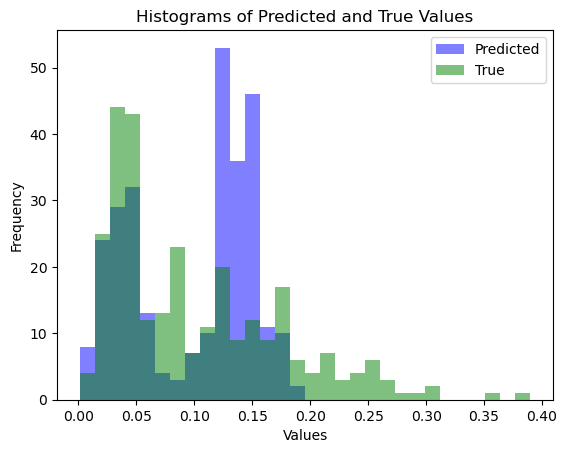

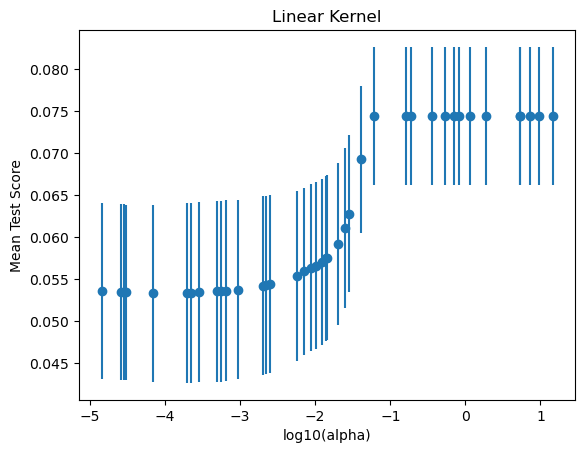

In [406]:
predicted_values = rand_lass.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_lass")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_lass", 'alpha')

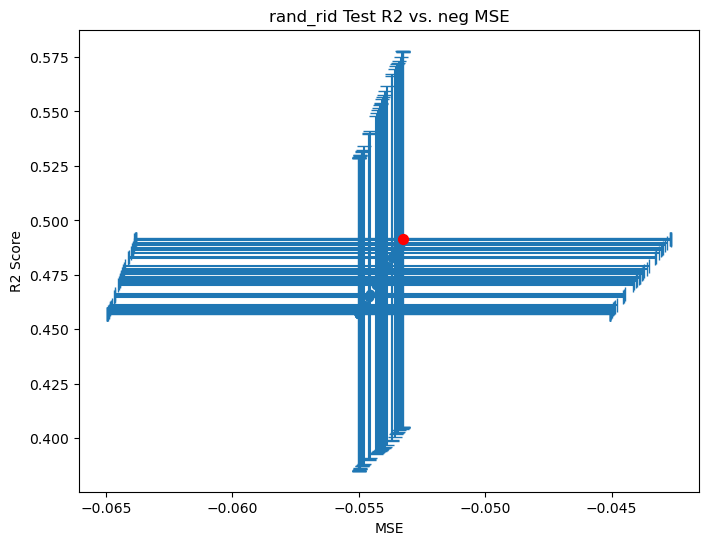

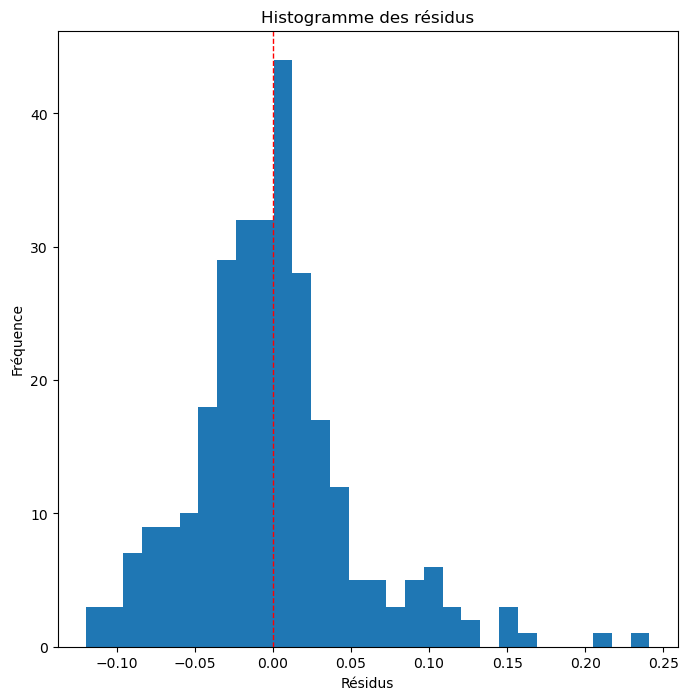

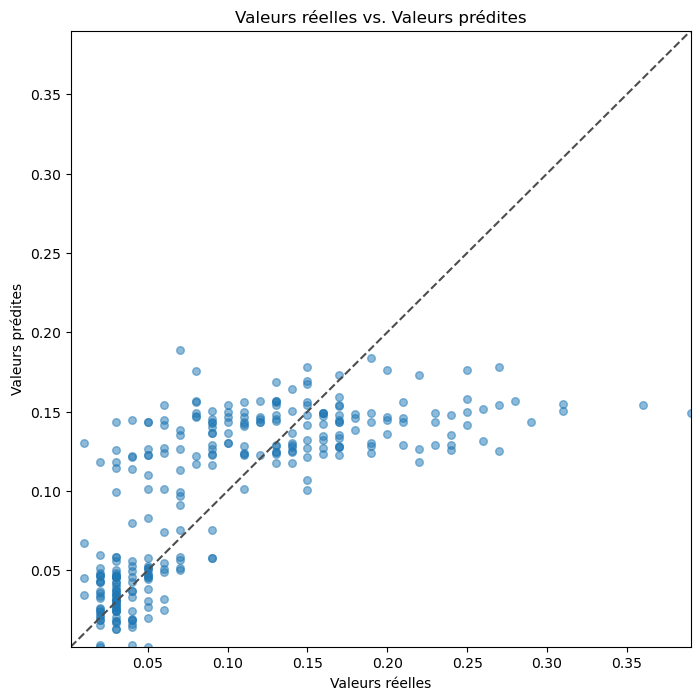

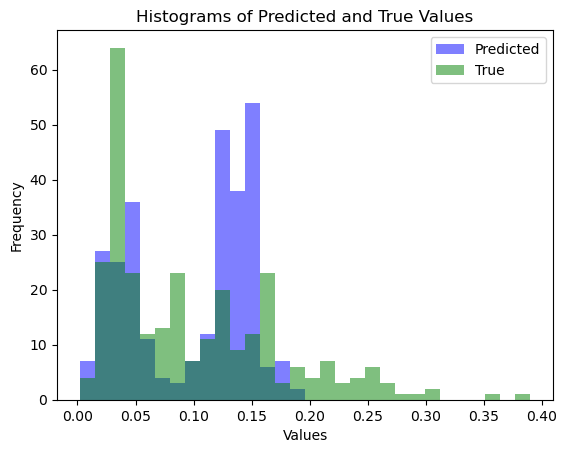

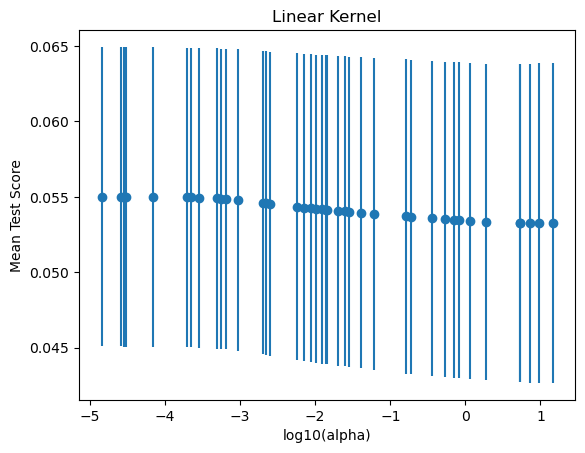

In [407]:
predicted_values = rand_rid.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_rid")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_rid", 'alpha')

In [408]:
param_dist_kr = {'mod__alpha': loguniform(1e-1, 5e1),
            'mod__gamma': loguniform(1e-4, 1e-1),
            'mod__kernel':['linear', 'poly', 'rbf', 'laplacian']}
#removed sigmoid because performance has too much variability and is no good

pKerR = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', KernelRidge())
])


rand_KerR = RandomizedSearchCV(pKerR, param_distributions=param_dist_kr, scoring=scorers, refit='mse',verbose=1, n_iter=50, cv=cv, random_state=7)

rand_KerR.fit(X_train, y_train.values.ravel())
exp_models["rand_KerR"]=rand_KerR
print("Best hyperparameters: ", rand_KerR.best_params_)
print("Cross-validation score: ", rand_KerR.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters:  {'mod__alpha': 0.4025144906550763, 'mod__gamma': 0.0053038076180245055, 'mod__kernel': 'poly'}
Cross-validation score:  -0.05246523434678498


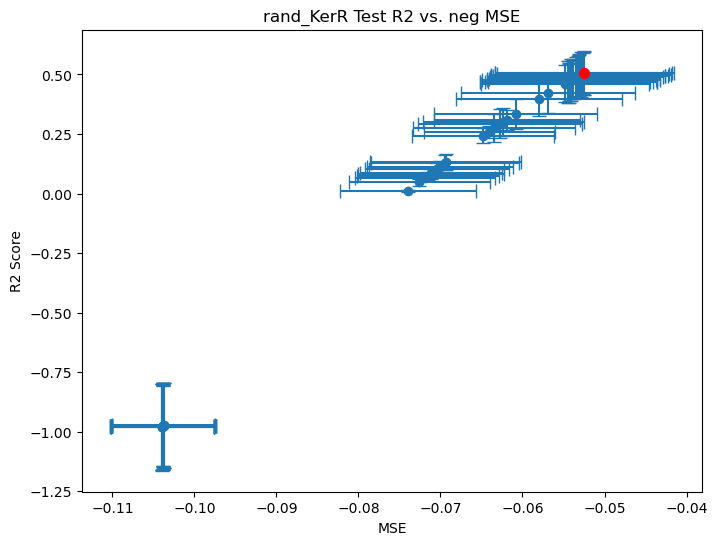

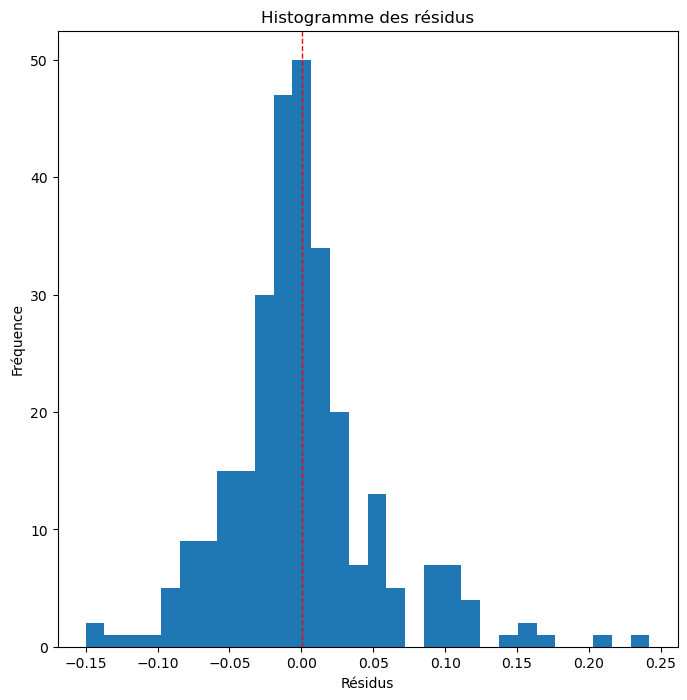

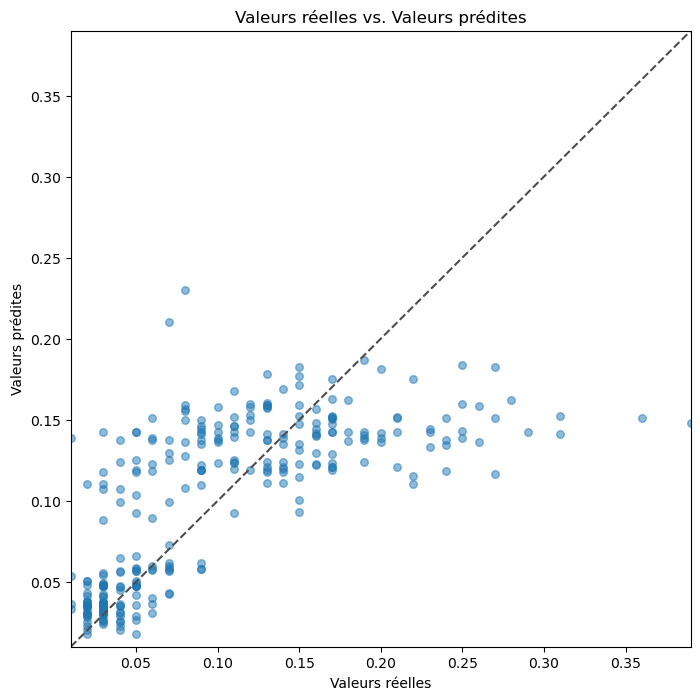

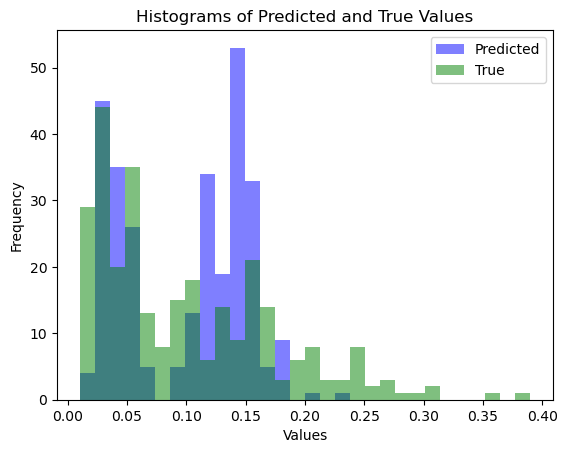

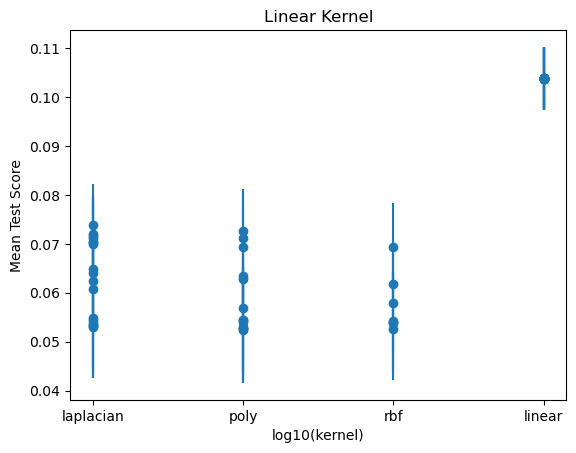

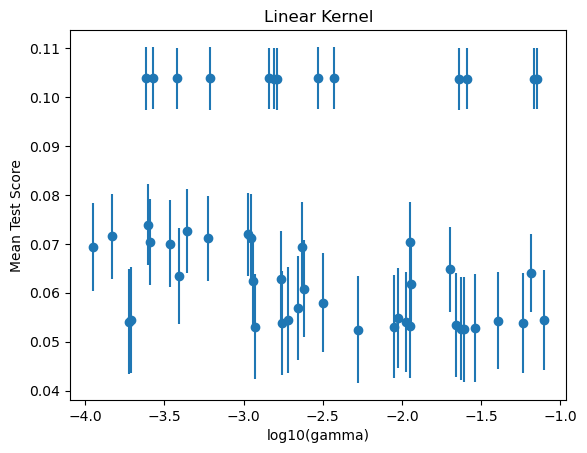

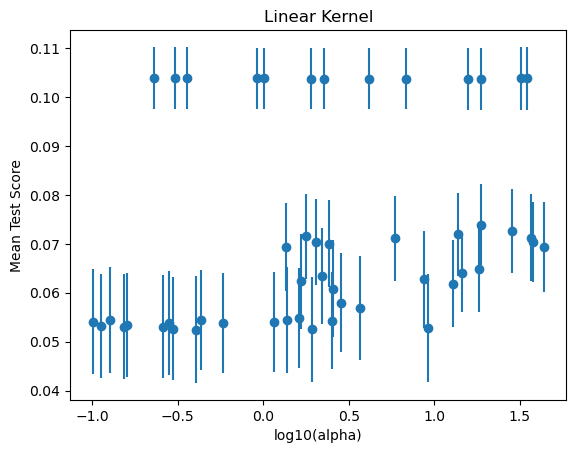

In [409]:
predicted_values = rand_KerR.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_KerR")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param("rand_KerR", 'kernel')
trend_param_log("rand_KerR", 'gamma')
trend_param_log("rand_KerR", 'alpha')

In [410]:
pSVRlin = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', SVR(kernel='linear'))
])

param_dist_lin = {'mod__C': loguniform(1e-4, 1e1), 
              'mod__epsilon': loguniform(1e-3, 1)}

rand_lin = RandomizedSearchCV(pSVRlin, param_distributions=param_dist_lin, scoring=scorers, refit='mse',verbose=1, n_iter=20, cv=cv, random_state=7)

rand_lin.fit(X_train, y_train.values.ravel())
exp_models["rand_lin"]=rand_lin
print("Best hyperparameters: ", rand_lin.best_params_)
print("Cross-validation score: ", rand_lin.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'mod__C': 0.6970076305466801, 'mod__epsilon': 0.008749516039671548}
Cross-validation score:  -0.053412411516581694


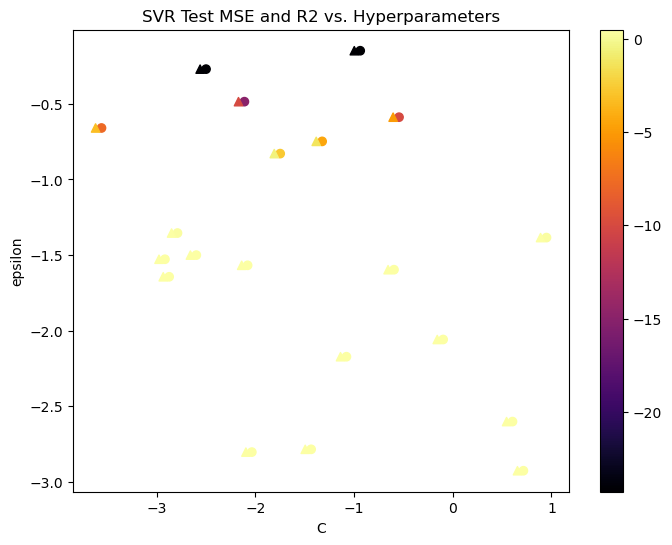

In [411]:
C_values = rand_lin.cv_results_['param_mod__C'].data
epsilon_values = rand_lin.cv_results_['param_mod__epsilon'].data
mean_test_scores = rand_lin.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_lin.cv_results_['mean_test_r2']

plt.figure(figsize=(8, 6))
plt.scatter(np.array([np.log10(float(c))+0.06 for c in C_values]), np.array([np.log10(float(e)) for e in epsilon_values]), c=mean_test_scores, cmap='inferno', marker='o')
plt.scatter(np.array([np.log10(float(c)) for c in C_values]), np.array([np.log10(float(e)) for e in epsilon_values]), c=mean_test_r2_scores, cmap='inferno', marker='^')
plt.colorbar()
plt.xlabel('C')
plt.ylabel('epsilon')
plt.title('SVR Test MSE and R2 vs. Hyperparameters')
plt.show()

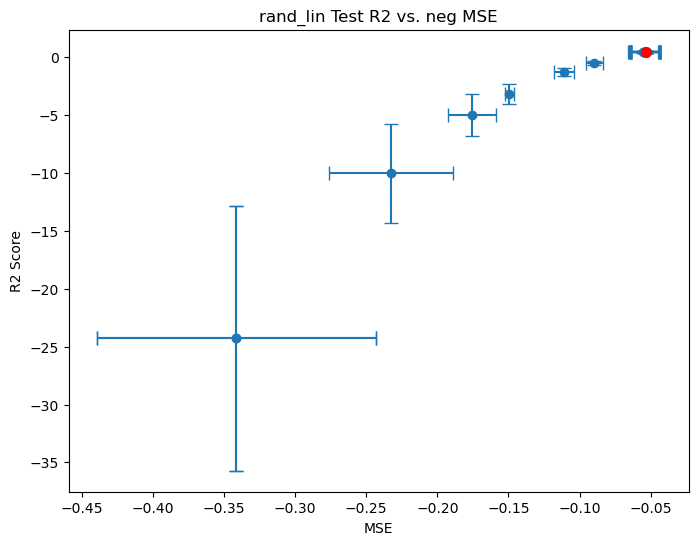

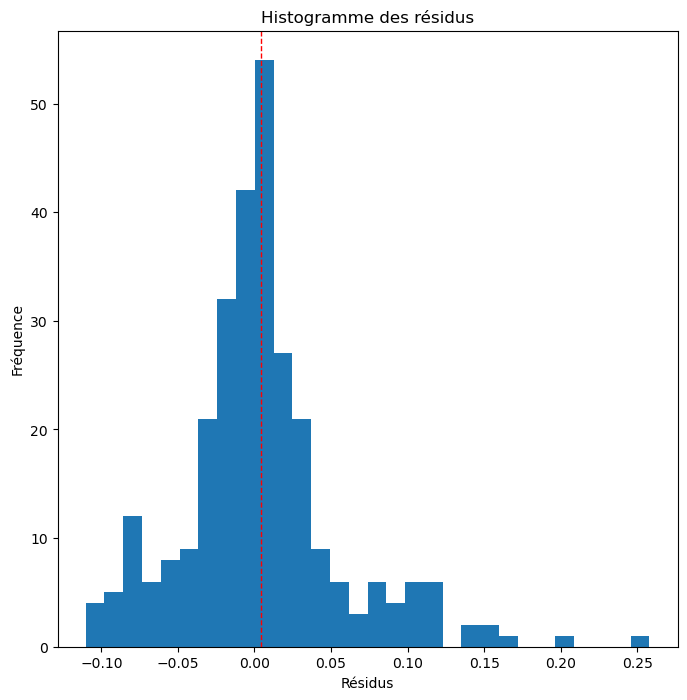

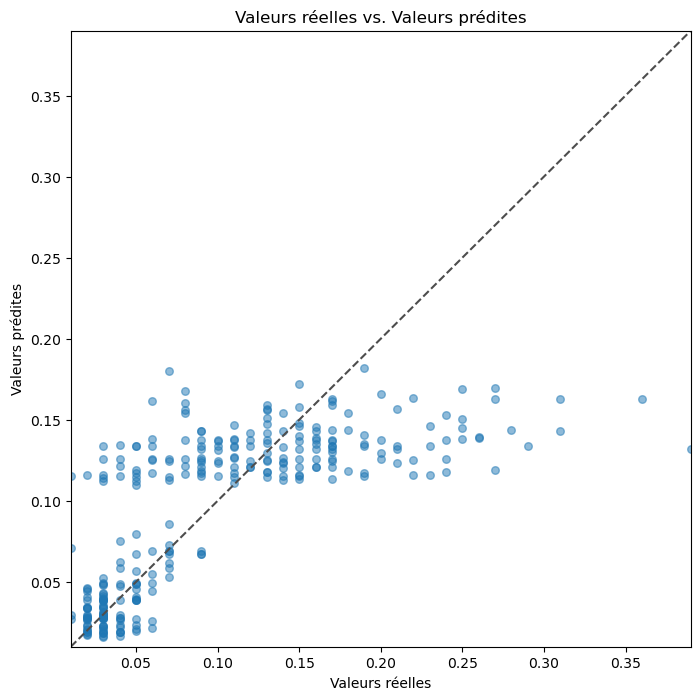

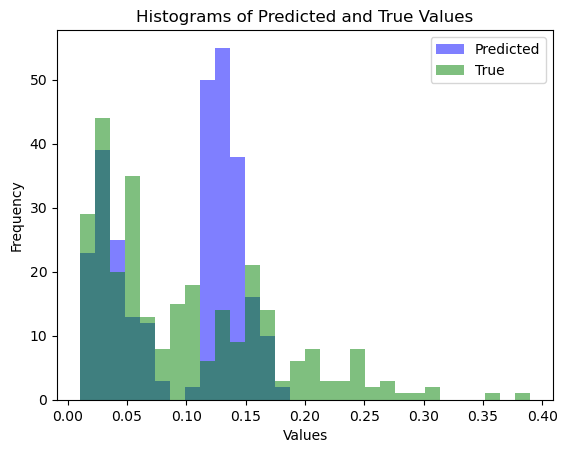

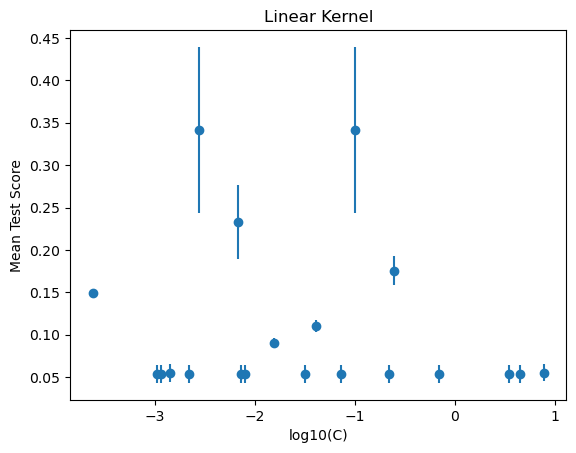

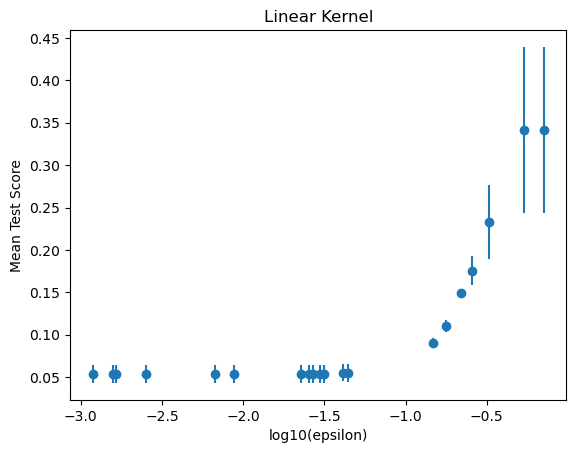

In [412]:
predicted_values = rand_lin.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_lin")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_lin", 'C')
trend_param_log("rand_lin", 'epsilon')

In [413]:
pSVRrbf = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', SVR(kernel='rbf'))
])


param_dist_rbf = {'mod__C': loguniform(1e-4, 1e1), 
              'mod__epsilon': loguniform(1e-3, 1),
                  'mod__gamma': ['scale', 'auto']}

rand_rbf = RandomizedSearchCV(pSVRrbf, param_distributions=param_dist_rbf, 
                              scoring=scorers, refit='mse', verbose=1, cv=cv,
                              n_iter=20, random_state=7)

rand_rbf.fit(X_train, y_train.values.ravel())
exp_models["rand_rbf"]=rand_rbf
print("Best hyperparameters: ", rand_rbf.best_params_)
print("Cross-validation score: ", rand_rbf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'mod__C': 0.3950213897132019, 'mod__epsilon': 0.017337061403148127, 'mod__gamma': 'auto'}
Cross-validation score:  -0.05220036010617576


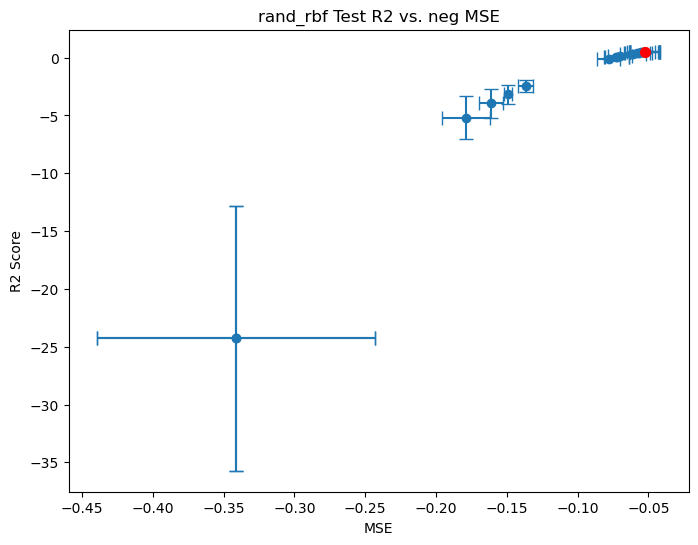

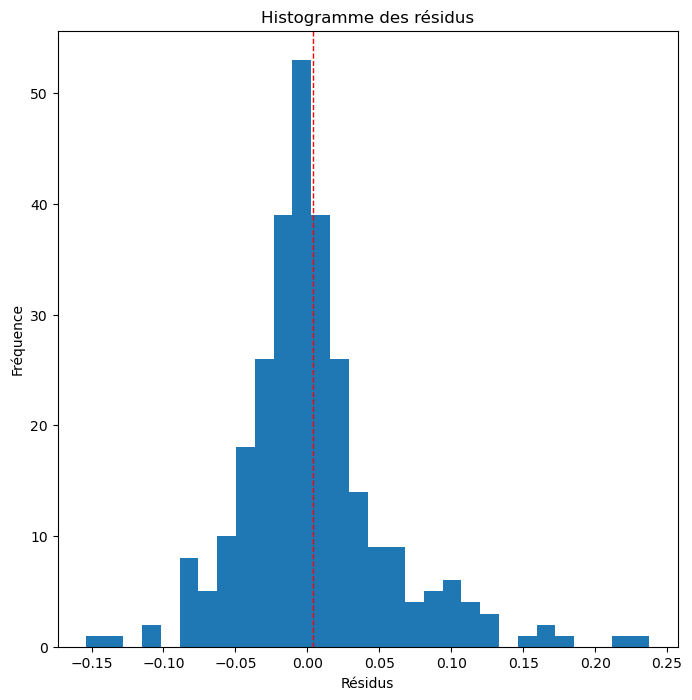

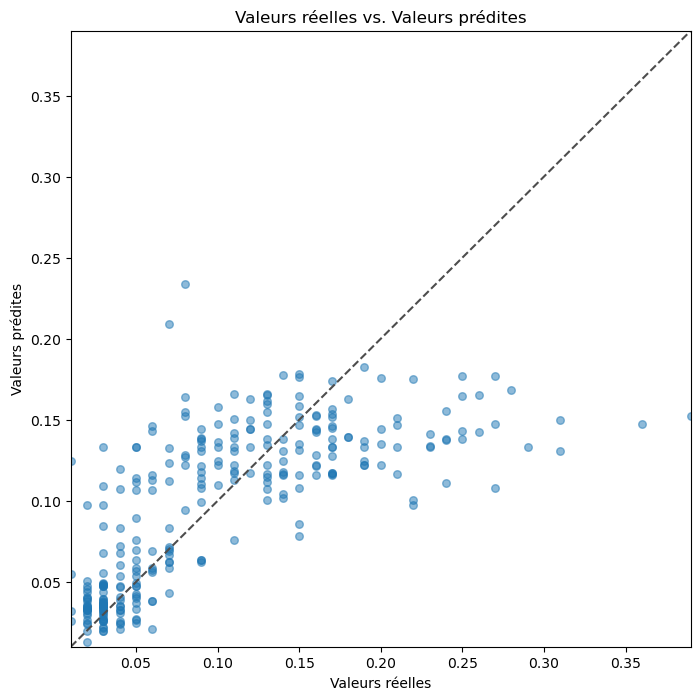

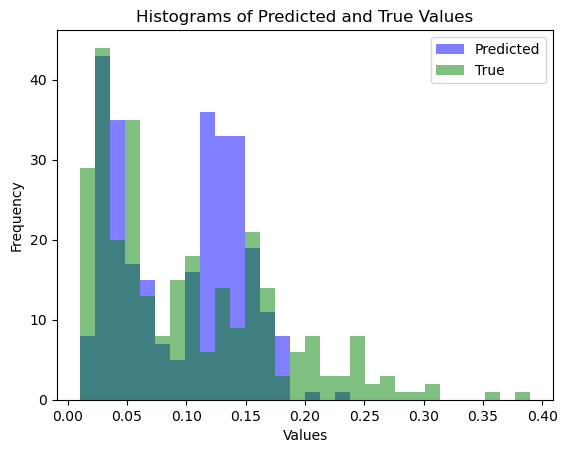

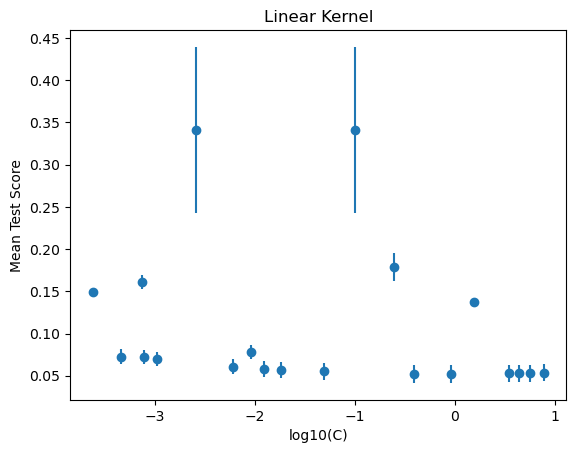

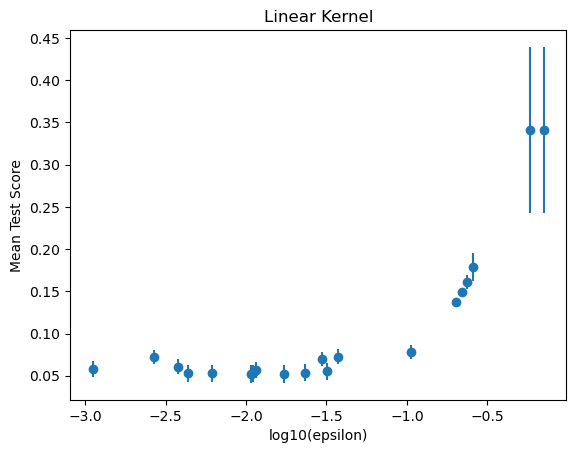

In [414]:
predicted_values = rand_rbf.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_rbf")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_rbf", 'C')
trend_param_log("rand_rbf", 'epsilon')

In [415]:
pSVRpoly = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', SVR(kernel='poly'))
])

param_dist_poly = {'mod__C': loguniform(1e-4, 1e1), 
              'mod__epsilon': loguniform(1e-3, 1),
                   'mod__degree':[2,3,4,5,6,7]}

rand_poly = RandomizedSearchCV(pSVRpoly, param_distributions=param_dist_poly, 
                                 n_iter=20, scoring=scorers, refit='mse', 
                                 verbose=1, cv=cv, random_state=7)

rand_poly.fit(X_train, y_train.values.ravel())
exp_models["rand_poly"]=rand_poly
print("Best hyperparameters: ", rand_poly.best_params_)
print("Cross-validation score: ", rand_poly.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'mod__C': 8.533274731577379, 'mod__degree': 3, 'mod__epsilon': 0.0034782024575460103}
Cross-validation score:  -0.054619696935691284


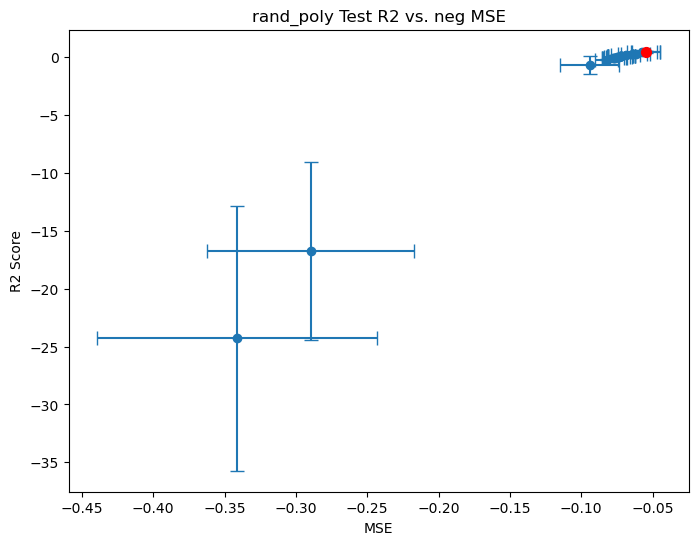

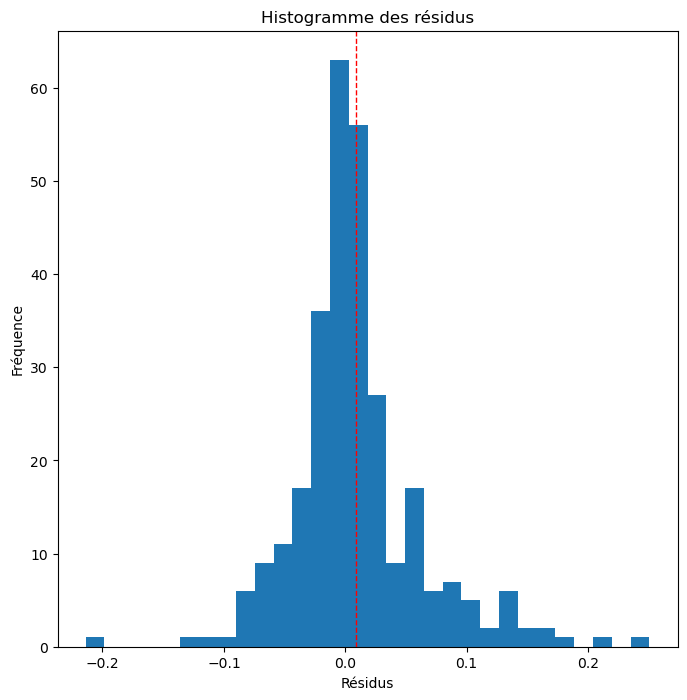

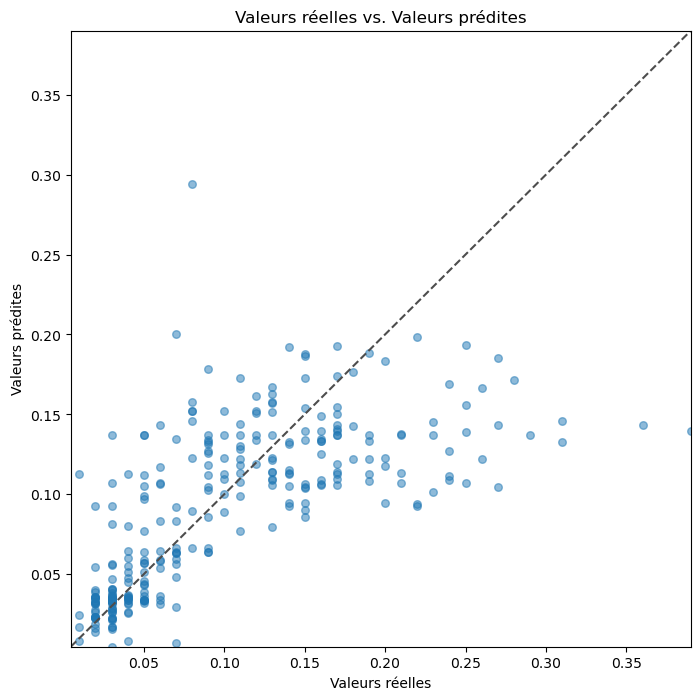

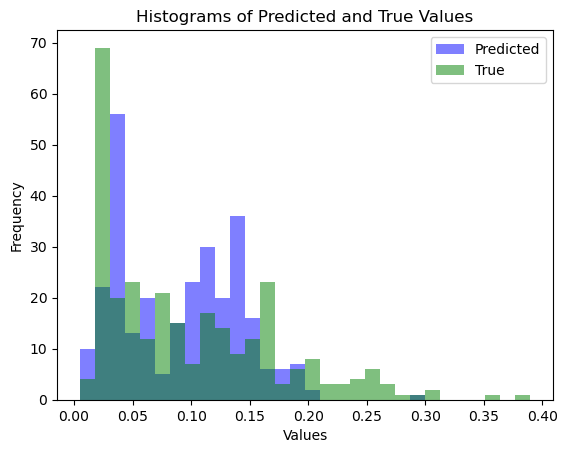

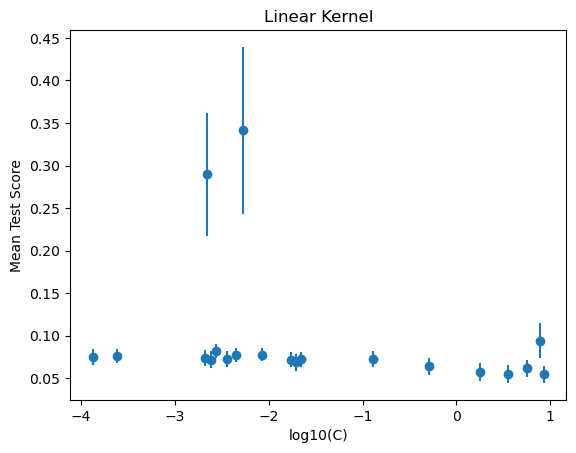

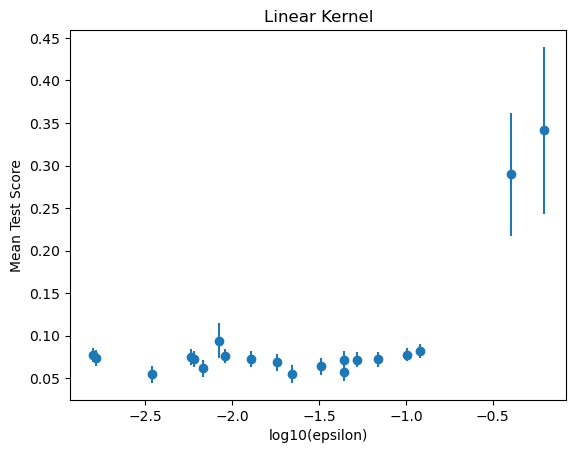

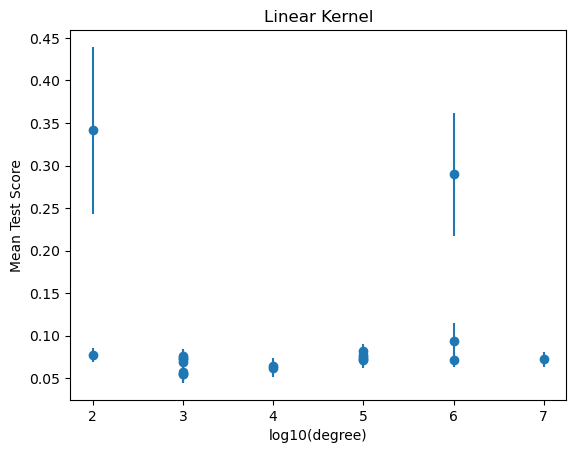

In [416]:
predicted_values = rand_poly.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_poly")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_poly", 'C')
trend_param_log("rand_poly", 'epsilon')
trend_param("rand_poly", 'degree')

In [417]:
pSVRsigmoid = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', SVR(kernel='sigmoid'))
])


param_grid_sig = {'mod__C': loguniform(1e-5, 5e-2), 
              'mod__epsilon': loguniform(1e-4, 1)}

rand_sig = RandomizedSearchCV(pSVRsigmoid, param_distributions=param_grid_sig,
                              scoring=scorers, refit='mse', verbose=1, cv=cv, n_iter=20,random_state=7)

rand_sig.fit(X_train, y_train.values.ravel())
exp_models["rand_sig"]=rand_sig
print("Best hyperparameters: ", rand_sig.best_params_)
print("Cross-validation score: ", rand_sig.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'mod__C': 0.0029830457258717426, 'mod__epsilon': 0.00743038708702432}
Cross-validation score:  -0.06516685352185213


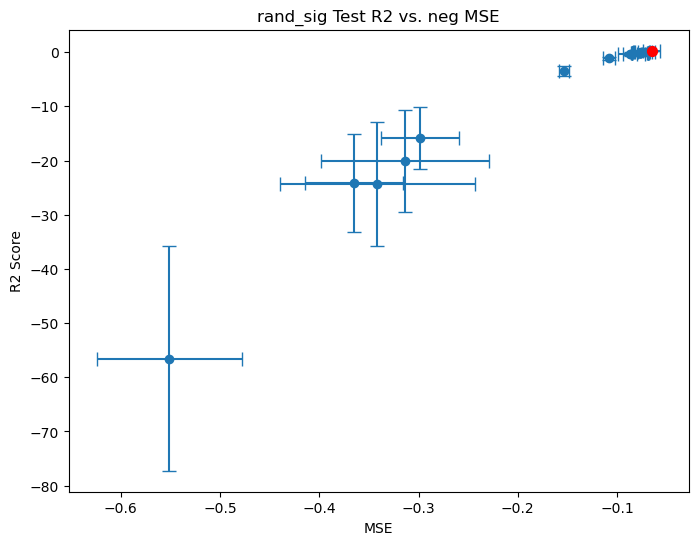

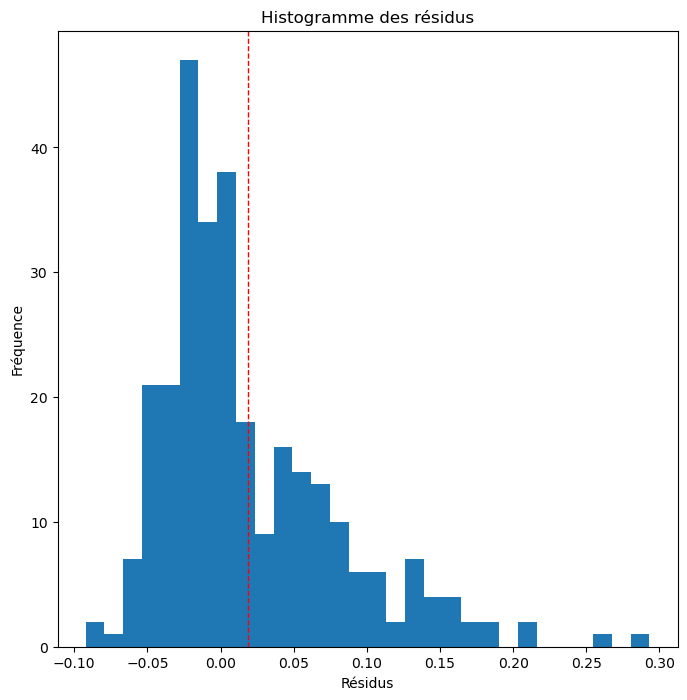

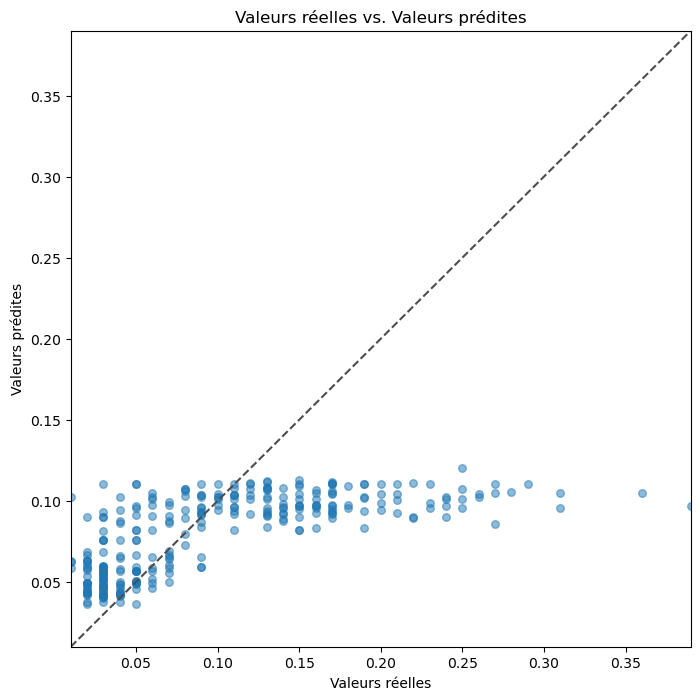

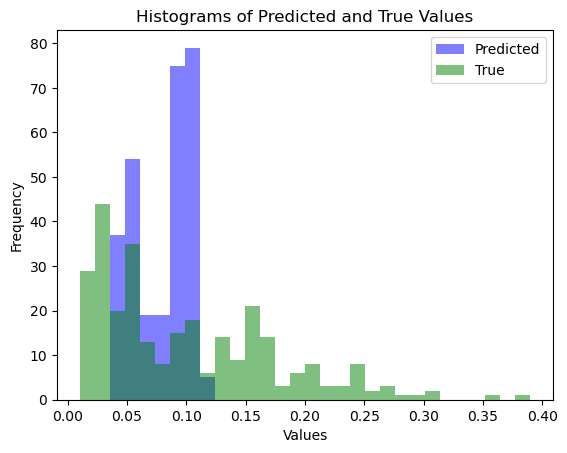

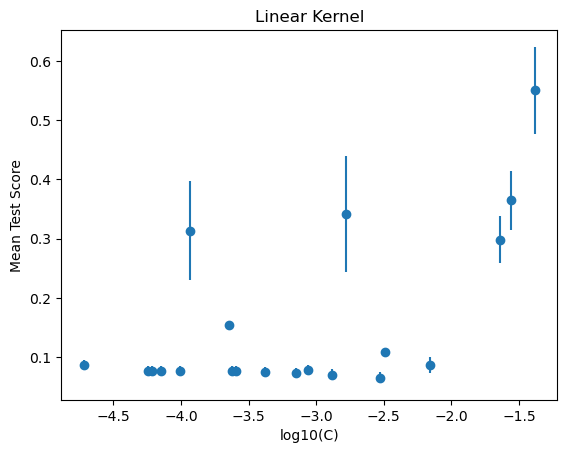

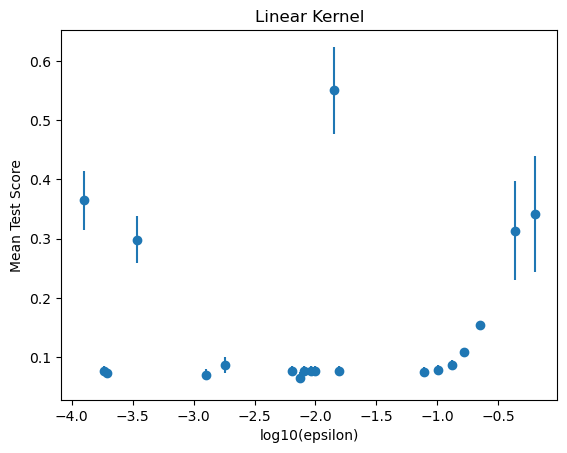

In [418]:
predicted_values = rand_sig.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_sig")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_sig", 'C')
trend_param_log("rand_sig", 'epsilon')

In [419]:
pRT = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', RandomForestRegressor())
])

param_dist_rt = {
    'mod__n_estimators': [10, 50, 100],
    'mod__max_depth': [2, 4, 6, None],
    'mod__min_samples_split': [2, 5, 10],
    'mod__min_samples_leaf': [1, 2, 4],
}


rand_rt = RandomizedSearchCV(estimator=pRT, param_distributions=param_dist_rt, 
                             n_iter=20, cv=cv, random_state=7, 
                             scoring=scorers, refit='mse', verbose=1)

rand_rt.fit(X_train, y_train.values.ravel())
exp_models["rand_rt"]=rand_rt
print("Best hyperparameters:", rand_rt.best_params_)
print("Best cross-validation score:", rand_rt.best_score_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'mod__n_estimators': 50, 'mod__min_samples_split': 2, 'mod__min_samples_leaf': 4, 'mod__max_depth': 4}
Best cross-validation score: -0.05265791486999292


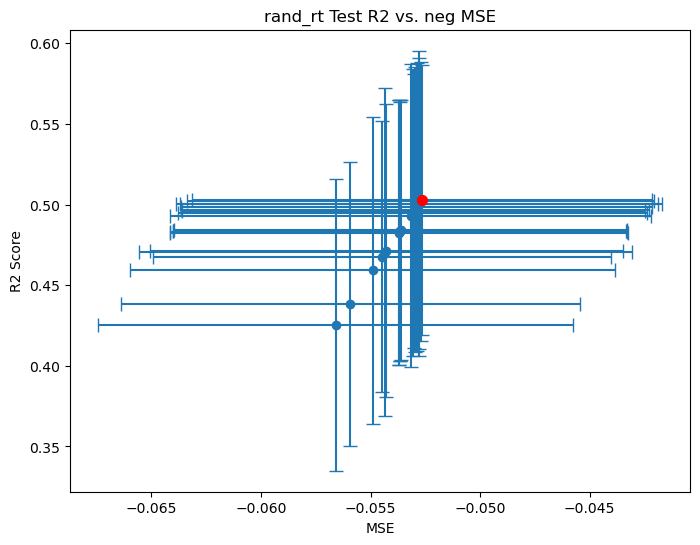

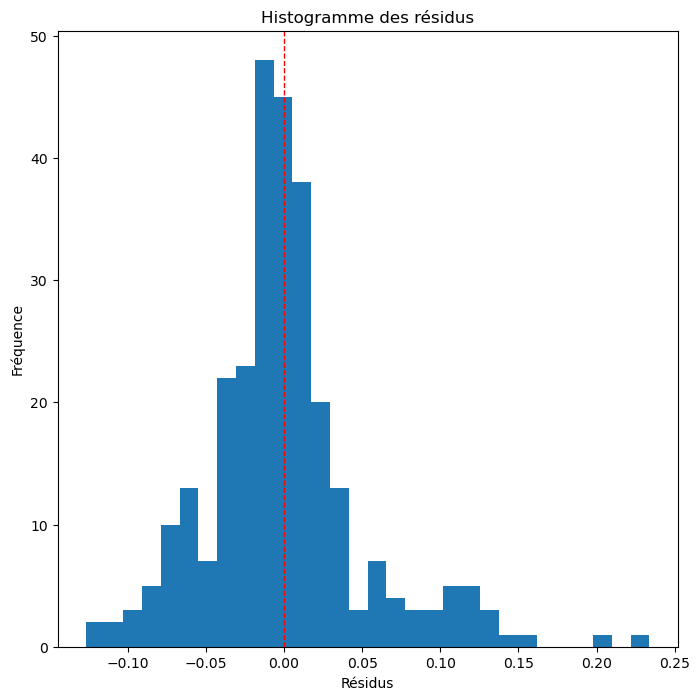

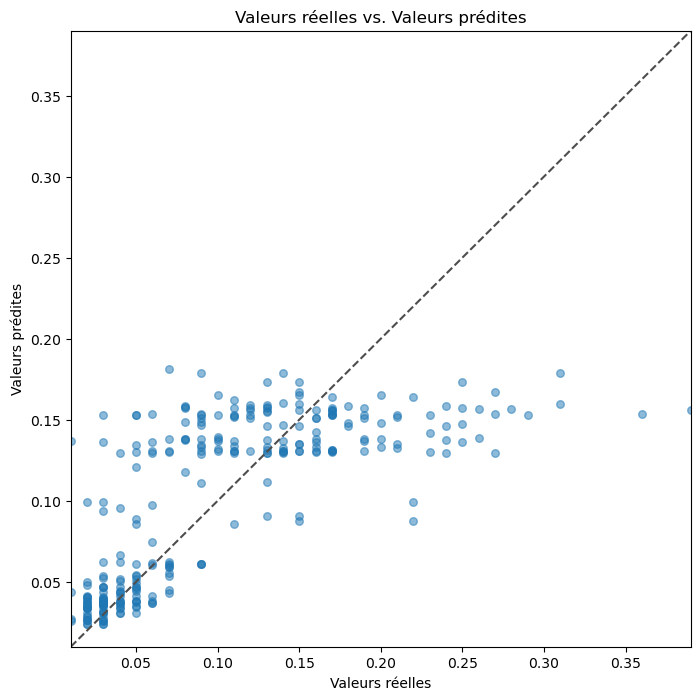

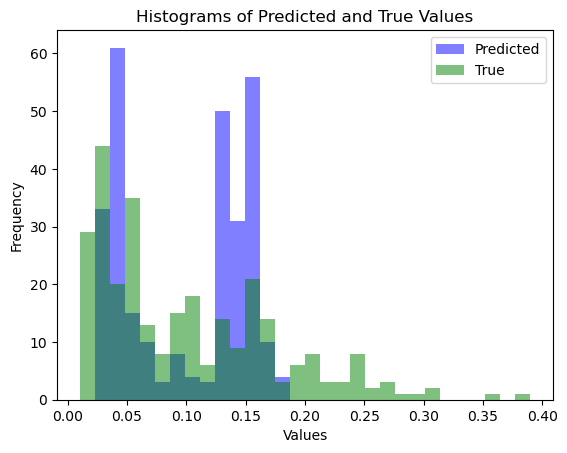

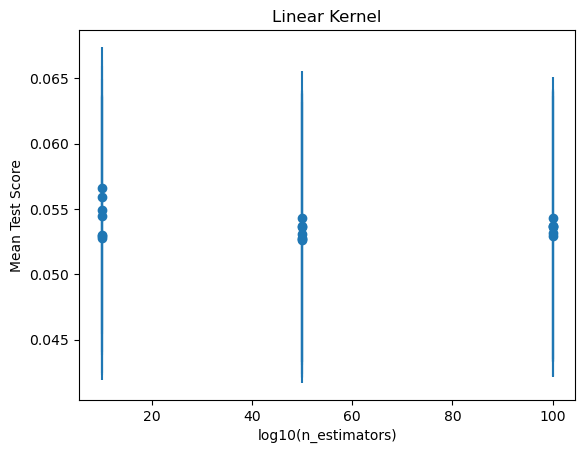

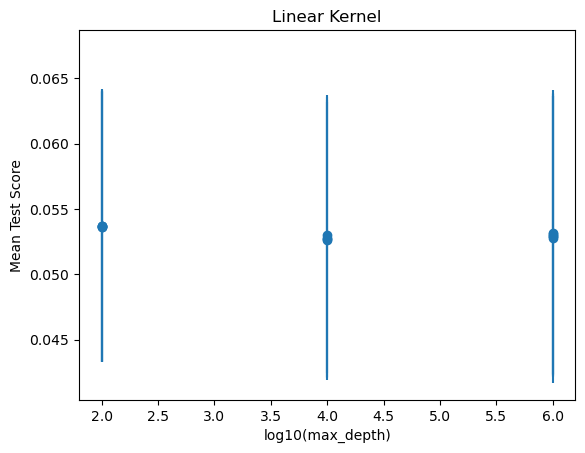

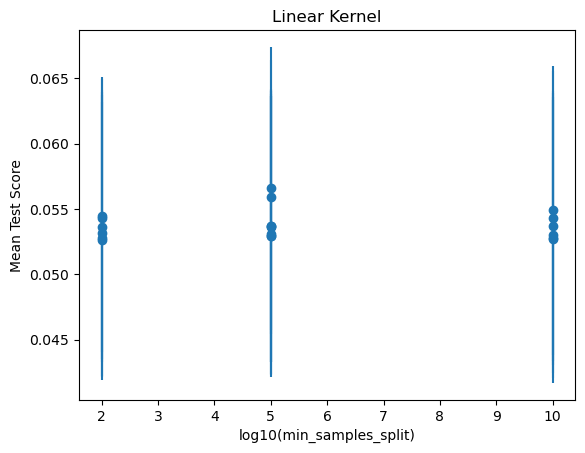

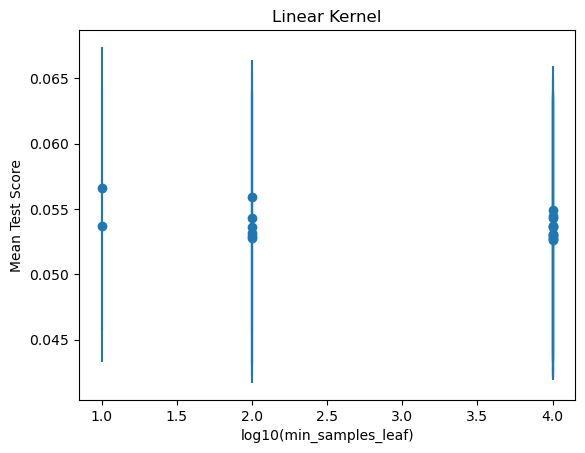

In [420]:
predicted_values = rand_rt.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_rt")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param("rand_rt", 'n_estimators')
trend_param("rand_rt", 'max_depth')
trend_param("rand_rt", 'min_samples_split')
trend_param("rand_rt", 'min_samples_leaf')

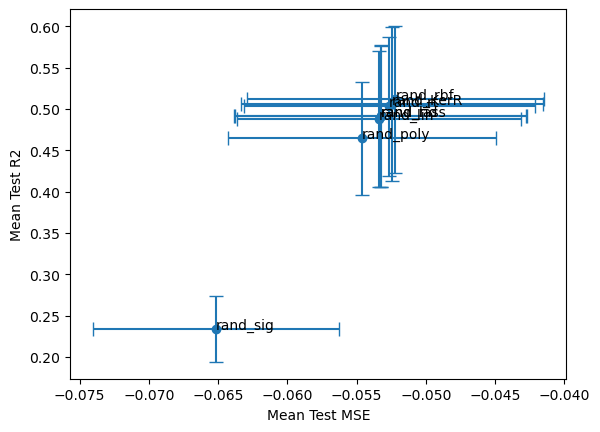

In [421]:
mse_scores = []
mse_err = []
r2_scores = []
r2_err = []
model_names = []

for key, model in exp_models.items():
    mse_scores.append(model.cv_results_['mean_test_mse'][model.best_index_])
    r2_scores.append(model.cv_results_['mean_test_r2'][model.best_index_])
    mse_err.append(model.cv_results_['std_test_mse'][model.best_index_])
    r2_err.append(model.cv_results_['std_test_r2'][model.best_index_])
    model_names.append(key)

fig, ax = plt.subplots()
plt.errorbar(mse_scores, r2_scores, xerr = mse_err ,yerr=r2_err, fmt='o', capsize=5)
for i, txt in enumerate(model_names):
    ax.annotate(txt, (mse_scores[i], r2_scores[i]))
ax.set_xlabel('Mean Test MSE')
ax.set_ylabel('Mean Test R2')
plt.show()

In [422]:
mse_scores

[-0.05327788423347224,
 -0.05325098705093982,
 -0.05246523434678498,
 -0.053412411516581694,
 -0.05220036010617576,
 -0.054619696935691284,
 -0.06516685352185213,
 -0.05265791486999292]

In [423]:
model_data = [(model_names[i], mse_scores[i],mse_err[i],r2_scores[i],r2_err[i]) for i in range(len(model_names))]
sorted_model_data = sorted(model_data, key=lambda x: x[1], reverse=True)
models_sorted = pd.DataFrame(sorted_model_data, columns=['Model Name', 'MSE Score', 'MSE std ', 'R2 score', 'R2 std'])
display(models_sorted)

,Model Name,MSE Score,MSE std,R2 score,R2 std
0,rand_rbf,-0.052200,0.010706,0.511470,0.088857
1,rand_KerR,-0.052465,0.010900,0.506347,0.093130
2,rand_rt,-0.052658,0.010497,0.502925,0.083782
3,rand_rid,-0.053251,0.010577,0.491419,0.086247
4,rand_lass,-0.053278,0.010537,0.490887,0.085522
5,rand_lin,-0.053412,0.010260,0.487931,0.081893
6,rand_poly,-0.054620,0.009672,0.464350,0.068326
7,rand_sig,-0.065167,0.008884,0.233866,0.039888


In [424]:
best_model_name = model_names[mse_scores.index(max(mse_scores))]
best_model = exp_models[model_names[mse_scores.index(max(mse_scores))]]

y_pred = best_model.predict(X_test)
y_true = y_test.values.ravel()
mse = np.mean((y_true- y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
y_range = np.max(y_true) - np.min(y_true)

print(tested)
print(best_model_name)
print('* relative MAE:', mae/y_range)
print('* R²:', r2)

print("* relative RMSE", rmse/y_range)

print("* MSE", mse)

Wine.Tannin
rand_rbf
* relative MAE: 0.09330848548246781
* R²: 0.5182300409466181
* relative RMSE 0.13611604551181258
* MSE 0.0026753822409297415


# Results

## both_over
### Must.ph 
rand_rt
* relative MAE: 0.09510536959830257
* R²: 0.5888265835490736
* relative RMSE 0.1225820039852864
* MSE 0.033359994531098384
### Alcool
rand_KerR
* relative MAE: 0.1437609511652779
* R²: 0.2823879978864461
* relative RMSE 0.1971618813827564
* MSE 7.510615131353685

### Must.Brix
rand_KerR
* relative MAE: 0.1481175909119017
* R²: 0.14163513274053896
* relative RMSE 0.18482541615332412
* MSE 4.676221872715986

### Must.Tacid
rand_KerR
* relative MAE: 0.10835532953522904
* R²: 0.3123464410845558
* relative RMSE 0.14171844462158056
* MSE 0.020487808308633792

### Wine.Facid
rand_KerR
* relative MAE: 0.11917033781635437
* R²: 0.32575443535172555
* relative RMSE 0.1501980424264166
* MSE 0.012021931943476956

### Wine.Extract
rand_KerR
* relative MAE: 0.11407865636427912
* R²: 0.09359629311415829
* relative RMSE 0.1850280436990258
* MSE 7.297612951746688

### Wine.Tannin
rand_rbf
* relative MAE: 0.09330848548246781
* R²: 0.5182300409466181
* relative RMSE 0.13611604551181258
* MSE 0.0026753822409297415

I accept some data leak in my RFE because the class in sklearn is built to receive a dataframe and my datascaler looses that shape. A more rigorous approach would be to perform the cross validation by hand.

In [460]:
from sklearn.feature_selection import RFECV

Xcop = X_train.copy()
clm = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), temperatures.columns)  
    ],
    remainder='passthrough' 
)
Xcop = clm.fit_transform(Xcop)
Xcop = pd.DataFrame(Xcop, columns = X_train.columns)


selector = RFECV(rand_rt.best_estimator_.named_steps['mod'], step=1, scoring='neg_mean_squared_error', cv=5, min_features_to_select=1, verbose = 2)
selector.fit(Xcop, y_train.values.ravel())



Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 fe

RFECV(cv=5,
      estimator=RandomForestRegressor(max_depth=4, min_samples_leaf=4,
                                      n_estimators=50),
      scoring='neg_mean_squared_error', verbose=2)

In [ ]:
from sklearn.feature_selection import RFECV

Xcop = X_train.copy()
clm = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), temperatures.columns)  
    ],
    remainder='passthrough' 
)
Xcop = clm.fit_transform(Xcop)
Xcop = pd.DataFrame(Xcop, columns = X_train.columns)


selector_lass = RFECV(rand_lass.best_estimator_.named_steps['mod'], step=1, scoring='neg_mean_squared_error', cv=5, min_features_to_select=1, verbose=1)
selector_lass.fit(Xcop, y_train.values.ravel())


SVR(C=0.3950213897132019, epsilon=0.017337061403148127, gamma='auto')


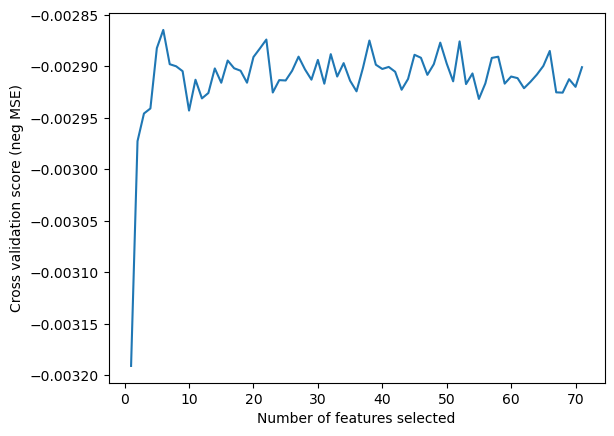

In [466]:
scores = selector.cv_results_['mean_test_score']

# Plot the scores against number of features
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg MSE)")
plt.plot(range(1, len(scores) + 1), scores)
plt.show()


In [465]:
selector.cv_results_

{'mean_test_score': array([-0.00319117, -0.00297262, -0.00294573, -0.00294083, -0.0028822 ,
        -0.00286446, -0.00289778, -0.00289983, -0.00290458, -0.00294288,
        -0.00291291, -0.00293103, -0.0029258 , -0.0029019 , -0.00291581,
        -0.00289421, -0.00290175, -0.00290414, -0.00291578, -0.00289082,
        -0.00288248, -0.00287382, -0.0029253 , -0.00291327, -0.00291362,
        -0.00290417, -0.00289045, -0.00290286, -0.00291283, -0.00289361,
        -0.00291675, -0.00288802, -0.00290977, -0.00289674, -0.00291381,
        -0.00292418, -0.00290132, -0.00287478, -0.00289828, -0.00290242,
        -0.00290044, -0.00290516, -0.00292262, -0.00291214, -0.00288865,
        -0.00289155, -0.00290816, -0.00289775, -0.00287682, -0.00289717,
        -0.00291446, -0.00287563, -0.00291712, -0.00290679, -0.00293155,
        -0.00291644, -0.00289167, -0.0028905 , -0.0029167 , -0.00290978,
        -0.00291135, -0.00292115, -0.00291492, -0.00290786, -0.0028995 ,
        -0.00288491, -0.00292516

In [445]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Example dataframe
df = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6]
})

# Define the column transformer with StandardScaler and output as DataFrame
ct = make_column_transformer(
    (StandardScaler(), ['A', 'B']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Fit and transform the dataframe using the column transformer
df_transformed = ct.fit_transform(df)

# Check the type of the output
print(type(df_transformed))


<class 'numpy.ndarray'>


In [ ]:
!pip install sklearn-pandas

In [449]:
from sklearn_pandas import DataFrameStandardScaler

scaler = DataFrameStandardScaler()
X_train_scaled = scaler.fit_transform(Xcop)

ImportError: cannot import name 'DataFrameStandardScaler' from 'sklearn_pandas' (/home/augustin/Documents/M1/projectML/project/projet_wine/.conda/lib/python3.10/site-packages/sklearn_pandas/__init__.py)

```python
model_results = {}
            
def compare_models_mse(k1,k2):
    m1 = exp_models[k1]
    m2 = exp_models[k2]
    scores1 =  [m1.cv_results_['split{}_test_mse'.format(i)][m1.best_index_] for i in range(5)]
    scores2 =  [m1.cv_results_['split{}_test_mse'.format(i)][m2.best_index_] for i in range(5)]
    t, p = ttest_rel(scores1, scores2)
    if p<0.05:
        if t<0:
            print(f'model {k2} better than {k1} (ttest)')
        elif t>0:
            print(f'model {k1} better than {k2} (ttest)')
    _, p = wilcoxon(scores1, scores2)
    if p<0.05:
        _, p = wilcoxon(scores1, scores2, alternative= "greater")
        if p<0.05:
            print(f'model {k1} better than {k2} (wilcoxon)')
        else:
            _, p = wilcoxon(scores1, scores2, alternative= "less")
            if p<0.05:
                print(f'model {k2} better than {k1} (wilcoxon)')

def compare_models_r2(k1,k2):
    m1 = exp_models[k1]
    m2 = exp_models[k2]
    scores1 =  [m1.cv_results_['split{}_test_r2'.format(i)][m1.best_index_] for i in range(5)]
    scores2 =  [m1.cv_results_['split{}_test_r2'.format(i)][m2.best_index_] for i in range(5)]
    t, p = ttest_rel(scores1, scores2)
    if p<0.05:
        if t<0:
            print(f'model {k2} better than {k1} (ttest)')
        elif t>0:
            print(f'model {k1} better than {k2} (ttest)')
    _, p = wilcoxon(scores1, scores2)
    if p<0.05:
        _, p = wilcoxon(scores1, scores2, alternative= "greater")
        if p<0.05:
            print(f'model {k1} better than {k2} (wilcoxon)')
        else:
            _, p = wilcoxon(scores1, scores2, alternative= "less")
            if p<0.05:
                print(f'model {k2} better than {k1} (wilcoxon)')
```

```python
tested_model = "rand_rt"
for key in exp_models.keys():
    if tested_model != key:
        compare_models_mse(tested_model, key)

print()
print()
for key in exp_models.keys():
        compare_models_r2(tested_model, key)
```

